I called it Chip Dip. It's kinda like riding the Warren Buffet wave; when the Buffets "buy the dip", we buy too, but we sell shortly after.

I looked into it a while back. Sample size is atrocious: there's 6 trades since 2010 on the SPY. 5.3% total ROI over 12 years. That's 0.4% ROI a year. Mind you, it holds for only a few days, so it isn't capital*time intensive. I played with mixing in PSAR, DI±, 2 EMAs, and even bracketed exits. They either perform much worse or they extend the holding period too long, bag-holding through every correction/bear market. That's a lot of time for money to be tied up. I think the point is that it shouldn't be tied up for long, freeing it up to invest in a different dipping ticker.

The key to this one would be finding tickers that are not highly correlated. If we did this on SPY and QQQ, we'll find that they both trigger at the same time, which does not help. I'm thinking a mixture of ETFs, including most of the SPDR ones but also GLD for gold and any other independent-minded ETFs, maybe WEAT. Chipmakers and XLK will be correlated but can try SPXL all the same. Short ETFs (SQQQ, SPXS, etc.) would be inversely correlated, which sounds great, but the algo relies on ETFs being long-biased (dips are exceptions to the trend), so not sure. VXX and UVXY would probably suck, unless we somehow played them upside-down, but then we hit correlation problems again.

Open to other ETF suggestions.

# Prep

In [1]:
%%capture
import sys; sys.path.append('../../..')

# Requires alpaca_trade_api backtrader matplotlib==3.2.2 plotly quantstats ta-lib (also requires talib C install)
from alpaca_trade_api.rest import REST, TimeFrame
import backtrader as bt
import matplotlib as mpl
import pytz
import datetime
from functools import lru_cache

import datetime

mpl.rcParams['figure.dpi'] = 250

%load_ext dotenv
import os
API_KEY = os.environ['APCA_API_KEY_ID']
SECRET_KEY = os.environ['APCA_API_SECRET_KEY']
assert API_KEY
assert SECRET_KEY
rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')

@lru_cache()
def get_pandas_data(symbol, timeframe, start, end):
  alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
  alpaca_data.index = alpaca_data.index.tz_convert("America/New_York")

  if timeframe != TimeFrame.Day:
    alpaca_data = alpaca_data.between_time(datetime.time(9, 30), datetime.time(16, 0), include_end=False)

  return alpaca_data

def run_backtest(strategy, symbol: str, start: datetime.date, end: datetime.date, params, cash: float, interval: TimeFrame):
  cerebro = bt.Cerebro(stdstats=True)
  cerebro.broker.setcash(cash)
  cerebro.addstrategy(strategy, **params)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
  cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")
  cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

  data_d = get_pandas_data(symbol, interval, start, end)
  feed1 = bt.feeds.PandasData(dataname=data_d, name=f"{symbol}-{interval}", tz=pytz.timezone('US/Eastern'))
  cerebro.adddata(feed1)

  results = cerebro.run()

  cerebro.plot(iplot=False) # if keep on True, re-running breaks quantstats charts from showing

  strat = results[0]
  return strat

# Strategy

In [10]:
symbol = 'SPY'
start = datetime.date(2010, 1, 1)
end = datetime.date(2022, 9, 1)
interval = TimeFrame.Day
cash = 500
strategy_name = f"{symbol}-chipdip"

In [11]:
class MyStrategy(bt.Strategy):
    params = dict(
      ema_period=200,
      rsi_period=14,
      rsi_entry_level=30,
      rsi_exit_level=40,
    )

    def __init__(self):
      self.rsi = bt.ind.RSI(period=self.p.rsi_period)

      self.ema = bt.ind.EMA(period=self.p.ema_period)
      self.buy_signal = bt.And(self.data.close > self.ema, self.rsi.rsi < self.p.rsi_entry_level)
      self.stay_signal = self.rsi.rsi < self.p.rsi_exit_level

      # self.buy_signal = self.rsi.rsi < self.p.rsi_entry_level

      # self.psar = bt.ind.ParabolicSAR()
      # self.buy_signal = bt.And(self.rsi.rsi < self.p.rsi_entry_level, self.data.close < self.psar.psar)
      
      # self.di = bt.ind.DI(period=14)
      # self.buy_signal = bt.And(self.rsi.rsi < self.p.rsi_entry_level, self.di.plusDI > self.di.minusDI)

      # self.adx = bt.ind.ADX()
      # self.buy_signal = bt.And(self.adx.adx < 20, self.rsi.rsi < self.p.rsi_entry_level)

      # self.ema1 = bt.ind.EMA(period=200)
      # self.ema2 = bt.ind.EMA(period=20)
      # self.buy_signal = bt.And(self.ema2 > self.ema1, self.rsi.rsi < self.p.rsi_entry_level)

    def next(self):
      # if not self.position and self.buy_signal:
      #   self.buy_bracket(size=1, limitprice=self.data.close[0]*1.05, stopprice=self.data.close[0]*0.1)

      if not self.position and self.buy_signal:
        self.order_target_size(target=1)
      if self.position and self.stay_signal:
        self.order_target_size(target=1)
      elif self.position and not self.stay_signal:
        self.order_target_size(target=0)
      else:
        self.order_target_size(target=0)


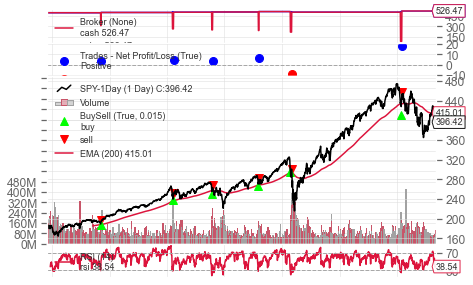

In [12]:
strategy = run_backtest(MyStrategy, symbol, start, end,
  {}
  , cash, interval
)

In [19]:
quantstats.reports.iDisplay(returns)

index
2015-12-01    0.0
2015-12-02    0.0
2015-12-03    0.0
2015-12-04    0.0
2015-12-07    0.0
             ... 
2022-08-26    0.0
2022-08-29    0.0
2022-08-30    0.0
2022-08-31    0.0
2022-09-01    0.0
Name: return, Length: 1701, dtype: float64

{'ema_period': 200, 'rsi_period': 14, 'rsi_entry_level': 30, 'rsi_exit_level': 40}


                           Strategy
-------------------------  ----------
Start Period               2015-12-01
End Period                 2022-09-01
Risk-Free Rate             0.0%
Time in Market             2.0%

Cumulative Return          5.29%
CAGR﹪                     0.77%

Sharpe                     0.3
Smart Sharpe               0.24
Sortino                    0.49
Smart Sortino              0.38
Sortino/√2                 0.35
Smart Sortino/√2           0.27
Omega                      1.45

Max Drawdown               -3.52%
Longest DD Days            903
Volatility (ann.)          2.62%
Calmar                     0.22
Skew                       2.68
Kurtosis                   144.02

Expected Daily %           0.0%
Expected Monthly %         0.06%
Expected Yearly %          0.65%
Kelly Criterion            15.47%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.27%
Expected Shortfall (cVaR)  -0.27%

Gain/Pain Ratio            0.45
Gain/Pain (1M)             1.61



None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-08-09,2020-02-28,2022-01-28,903,-3.520392,-1.641434
2,2018-02-07,2018-02-08,2019-08-06,545,-2.087075,-1.151894
3,2016-11-08,2016-11-08,2018-02-06,455,-0.077404,0.000000
4,2016-11-04,2016-11-04,2016-11-07,3,-0.064000,0.000000


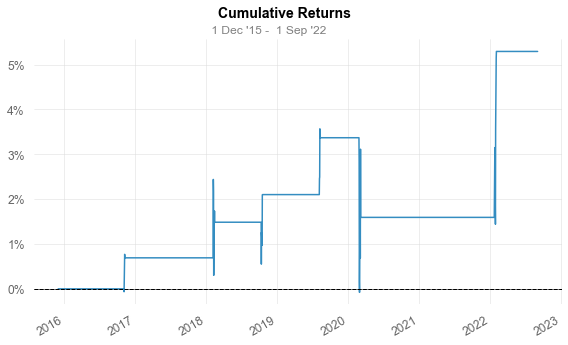

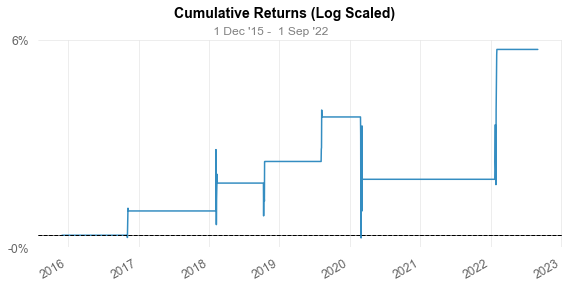

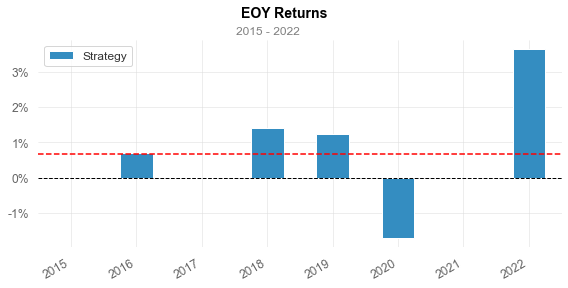

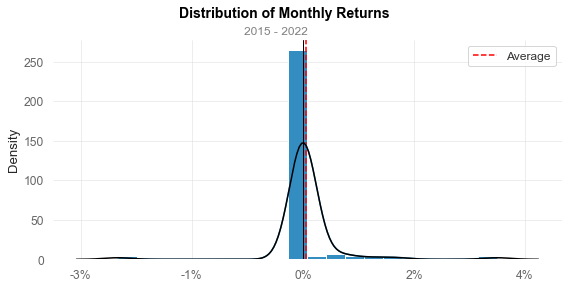

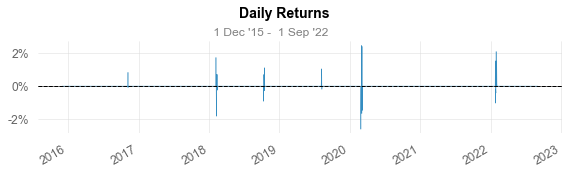

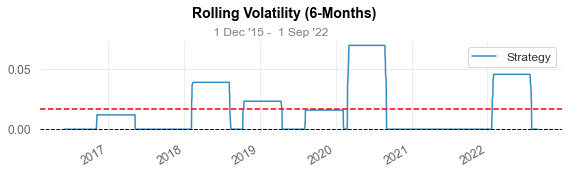

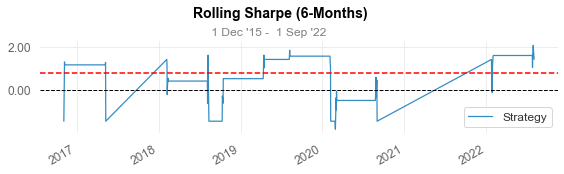

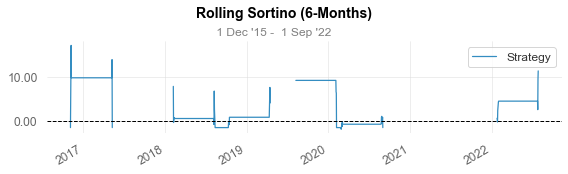

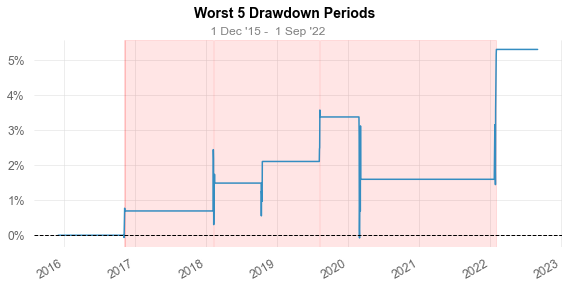

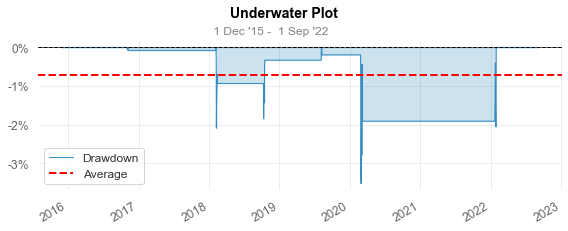

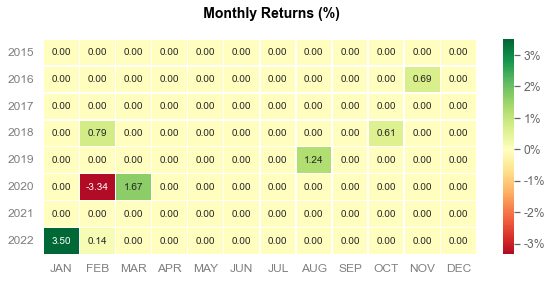

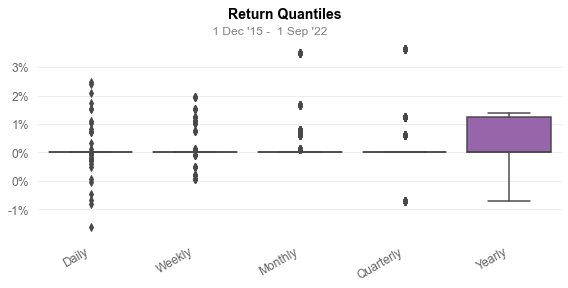

In [13]:
print(strategy.p.__dict__)
import quantstats
portfolio_stats = strategy.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
quantstats.reports.full(returns)

In [14]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2016-11-04 04:00:00+00:00,1,189.43,0,SPY-1Day,-189.43
2016-11-08 05:00:00+00:00,-1,192.89,0,SPY-1Day,192.89
2018-02-06 05:00:00+00:00,1,241.50,0,SPY-1Day,-241.50
2018-02-13 05:00:00+00:00,-1,245.47,0,SPY-1Day,245.47
2018-10-11 04:00:00+00:00,1,259.90,0,SPY-1Day,-259.90
2018-10-17 04:00:00+00:00,-1,262.98,0,SPY-1Day,262.98
2019-08-06 04:00:00+00:00,1,272.23,0,SPY-1Day,-272.23
2019-08-09 04:00:00+00:00,-1,278.57,0,SPY-1Day,278.57
2020-02-26 05:00:00+00:00,1,302.00,0,SPY-1Day,-302.00


In [15]:
from src.results import metadata, from_backtest
from src import types

transactions.index = transactions.index.tz_convert("America/New_York")
transactions['time'] = transactions.index

from_backtest.write_results(strategy_name, [types.FilledOrder(intention=None,
    symbol=t['symbol'].split('-')[0],  # because datasource is '{symbol}-{interval}', gotta remove the '-{interval}'
    quantity=t['amount'], price=t['price'], datetime=t['time'].to_pydatetime()) for t in transactions.to_dict('records')],
    metadata.from_context("", start, end, strategy.p.__dict__))
print(strategy_name)

SPY-chipdip


# Optimize

In [ ]:
raise NotImplemented()

In [ ]:
gridsearch = dict(
    # TODO: try parsar instead of 200ema
    # TODO: try adx instead of 200ema
    ema_period=[50, 100, 200, 250],
    rsi_entry_level=[20, 30, 40, 50],
    rsi_exit_level=[30, 40, 50, 60],
    rsi_period=[5, 9, 14],
)
time_per = datetime.timedelta(seconds=13)

choices = 1
for l in gridsearch.values():
  choices *= len(l)

estimated_time = time_per * choices
print(f"Estimated time (@ {time_per}, {choices}): {estimated_time}")
start_time = datetime.datetime.now()
print(f"(ending at {start_time + (time_per * choices)})")
print("=" * 80)

cerebro = bt.Cerebro(stdstats=True, maxcpus=1)  # inside of VS Code editor, this does not go well
cerebro.broker.setcash(cash)
cerebro.optstrategy(MyStrategy, **gridsearch)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annualreturn")

data1m = get_pandas_data(symbol, TimeFrame.Minute, start, end)
feed1 = bt.feeds.PandasData(dataname=data1m, name=f"{symbol}-1m", tz=pytz.timezone('US/Eastern'))
cerebro.adddata(feed1)

runs = cerebro.run()
backtest_results = [results[0] for results in runs]



end_time = datetime.datetime.now()
print(f"Done. Took {end_time - start_time}")
print(f"time per: {(end_time - start_time) / choices}")